# DFTs and Windowing 101 - Understanding how to handle LIGO data appropriately

This work is simply for understanding how to work with DFTs and windowing and how the associated corrections and windows help the analysis of the data and introduce more complicated corrections. This work follows Greg Mendell's Introduction to Signal Processing Talk (LIGO DCC: G1200759). 

In [69]:
# required imports for the code
import numpy as np
import scipy.signal as sg
import nds2

# Imports for plotting
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

params = {
   'axes.labelsize': 18,
   'font.size': 24,
   'legend.fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'axes.titlesize':18,
   'text.usetex': True,
   'figure.figsize': [8, 6],
   'font.family':'sans',
   'font.serif':'DejaVu'
   }
mpl.rcParams.update(params)

## Computing Discrete Fourier Transforms

We want to consider some generic digital data. The digital data is simply a time series with a value $x_j$ at each integer $j$. This corresponds to a time $t_j = j\Delta t$, where $\Delta t$ is the time spacing between samples, where the signal will be determined over a duration of $T$ with $N$ samples, meaning $j=0,1,2,...,N-1$ (note the convention of starting at $j=0$). Finally, in the time domain, we can also define a sampling frequency, $f_s = 1/\Delta t = N/T$. 

In [2]:
# Generate our j-indexed time domain data
N = 1000; T = 10
dt = T/N; fs = N/T
j = np.arange(0,N)
x = np.random.randn(N)
t = np.arange(0,T,dt)

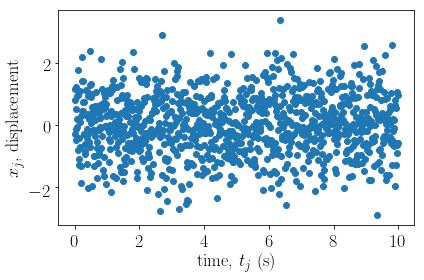

In [3]:
# Plotting the data
fig = plt.figure()
plt.plot(t,x, linestyle='', marker='o')
plt.xlabel(r'time, $t_j$ (s)')
plt.ylabel(r'$x_j$, displacement')
plt.tight_layout()
plt.show()

Now, for the discrete fourier transform (DFT), we consider a $\Delta f = 1/T$ as set by the duration of the signal. This can be interpreted as the frequency resolution is set by the longest possible period for sinusoids can be seen. This, again, allows us to define the frequencies of the frequency bins as $f_k = k\Delta f$ for integer $k$s, again set as $k = 0,1,2,...,N-1$.  

Now, we can therefore compute the DFT, which comes from the typical continuous definition of a Fourier transform, replaced with Riemannian sums for the integration and can then be computed. The DFT both to and from the frequency domain can be written as 

$$ \tilde{x}_k = \sum_{j=0}^{N-1}x_je^{-2\pi ijk/N}$$
$$ x_j = \frac{1}{N}\sum_{j=0}^{N-1}\tilde{x}_ke^{2\pi ijk/N}$$

Note that in practice we use the Fast Fourier Transform (FFT) which is a faster implementation of the DFT.

In [4]:
# Compute the frequency domain data
df = 1/T
x_tilde = np.fft.fft(x)
f = np.arange(0, fs, df)

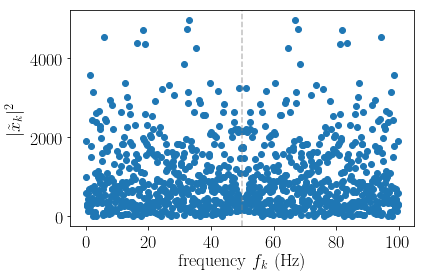

In [5]:
# Plotting the data
fig = plt.figure()
plt.plot(f, np.abs(x_tilde)**2, linestyle='', marker='o')
plt.xlabel(r'frequency $f_k$ (Hz)')
plt.ylabel(r'$|\tilde{x}_k|^2$')
plt.axvline(fs/2, color='grey', alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

From DFT here, we can note a few important features. 
1. The magnitude of the variable $x$ in the frequency domain is seeminlgy different and will be discussed further.
2. The FFT is mirrored about $f_s/2$. This means that you gain no information about the higher frequencies, and in fact, if the data is not bandpass filtered before an FFT, these higher frequencies can bleed into the true FFT. 
3. The above point allows for the definition of an upper limit for the frequencies within which information is contained. If we note that the right side is just a conjugation and mirror of the left side, we have that the domain we care about is 
$$ [0, f_s/2] = [0,f_N]$$ 
where $f_N$ is called the Nyquist frequency.

Note that the DFT is simply extracting the amplitude and phase of a given sinusoid. This written as
$$ \sum_{j=0}^{N-1}e^{2\pi ijk'/N}e^{-2\pi ijk/N} = N\delta_{kk'} $$
and demonstrated below.

In [6]:
# creating the exponential to fft, note 1j = sqrt(-1)
kp = T*40 # making the sinusoid have a frequency of 40 Hz from f_k T = k
x = np.exp(2*np.pi*1j*j*kp/N)

# compute the DFT
x_tilde = np.fft.fft(x)

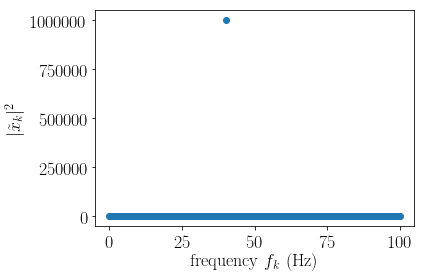

In [7]:
# Plotting the data
fig = plt.figure()
plt.plot(f, np.abs(x_tilde)**2, linestyle='', marker='o')
plt.xlabel(r'frequency $f_k$ (Hz)')
plt.ylabel(r'$|\tilde{x}_k|^2$')
plt.tight_layout()
plt.show()

This is the property of orthogonality of the DFT; such a property can be used for various different theorems you may encounter.

## Amplitudes of Lines and Spectral Leakage

A common feature of LIGO data is the presence of lines. First, we will consider a "bin centered" spectral line. This means that the spectral line is located at a frequency $f$ such that $fT$ is an integer. We will see why this is a problem shortly. 

To begin, we let $x$ be a cosine function, $$ x_j = A\cos(2\pi ft_j + \phi_0) = A\cos\Big(\frac{2\pi jk}{N} + \phi_0\Big) $$
Following through with a DFT by hand, one can find that at the frequency $f$, $\tilde{x}_k$ has the form
$$ \tilde{x}_{fT} = \frac{AN}{2}e^{i\phi_0} $$
and zero everywhere else. So how about we try this in the code!

In [8]:
A = 1; k = T*35.5; phi_0 = np.pi/3
x = A*np.cos(2*np.pi*j*k/N+phi_0)
x_tilde = np.fft.fft(x)

# Let us print the expected and determined values:
print('Expected amplitude    : {}'.format(A*N/2*np.exp(1j*phi_0)))
print('Determined amplitude  : {}'.format(x_tilde[int(k)]))

Expected amplitude    : (250.00000000000006+433.0127018922193j)
Determined amplitude  : (250.00000000001913+433.01270189220844j)


Pretty damn good! And a plot of $|\tilde{x}_k|^2$, again noting the existence of the image about $f_s/2$. 

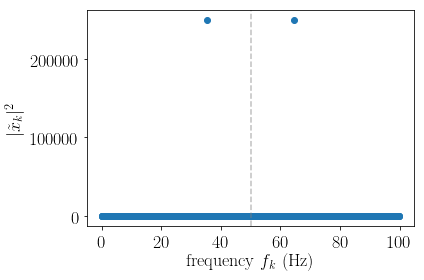

See that (N/2)^2 is: 250000.0


In [9]:
# Plotting the data
fig = plt.figure()
plt.plot(f, np.abs(x_tilde)**2, linestyle='', marker='o')
plt.xlabel(r'frequency $f_k$ (Hz)')
plt.ylabel(r'$|\tilde{x}_k|^2$')
plt.axvline(fs/2, color='grey', alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

print('See that (N/2)^2 is: {}'.format((N/2)**2))

Now, we can consider the idea of DFT leakage by asking the pertinent question, _what if the frequency of the sinusoid was not bin centered?_ 

To do this, we consider again a spectral line of the form
$$ x_j = A\cos(2\pi ft_j + \phi_0) = A\cos\Big(\frac{2\pi j\kappa}{N} + \phi_0\Big) $$
but here $\kappa = fT$ is not an integer, and is instead some shift away from than integer $\Delta \kappa = \kappa -k$. This implies that the bin is not centered on an integer value of $k$. 

Again, following through the algebra of a DFT, we can arrive that at the closest bin to the line follows

$$\tilde{x}_k = \frac{AN}{2} e^{i\phi_0} \Big[\frac{\sin(2\pi\Delta \kappa)}{2\pi\Delta\kappa} + i\frac{1-\cos(2\pi\Delta \kappa)}{2\pi\Delta\kappa}\Big]$$
TODO check if this is a plus or minus sign...
We can see that this is no longer some trivial amplitude of $AN/2$ and is much more complicated. Let us show this in the code too.

In [10]:
A = 1; k = T*25.57; phi_0 = np.pi/3
x = A*np.cos(2*np.pi*j*k/N+phi_0)
x_tilde = np.fft.fft(x)

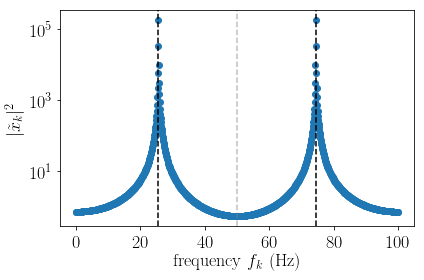

In [11]:
# Plotting the data
fig = plt.figure()
plt.semilogy(f, np.abs(x_tilde)**2, linestyle='', marker='o')
plt.xlabel(r'frequency $f_k$ (Hz)')
plt.ylabel(r'$|\tilde{x}_k|^2$')
plt.axvline(fs/2, color='grey', alpha=0.5, linestyle='--')
plt.axvline(25.57, color='black', linestyle='--')
plt.axvline(100-25.57, color='black', linestyle='--')
plt.tight_layout()
plt.show()

Note the logarithmic scale for $\tilde{x}_k$. We can see from this that the amplitude of the line is bleeding into the other frequency bins. This is precisely why frequencies of calibration lines within LIGO are set to frequency such that they are all bin centered and thus do not leak amplitude into other bins. 

Now, we need to consider how do we reduce this spectral leakage? To do this, we utilize windowing on the data.

## Windowing

Windowing is simply the multiplication of a time domain series which attempts to mitigate the leakage of spectral lines into neighboring bins. This mutliplication is done in the time domain, and can therefore be considered as a convolution in the frequency domain. Below are some examples of windows.

In [12]:
rect = np.ones(N); rect[0] = 0.; rect[-1]=0.
hann = np.hanning(N)
tukey = sg.tukey(N, alpha=0.5)

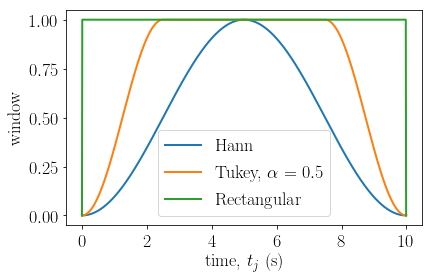

In [13]:
# Plotting the data
fig = plt.figure()
plt.plot(t,hann, linewidth=2, label=r'Hann')
plt.plot(t,tukey, linewidth=2, label=r'Tukey, $\alpha=0.5$')
plt.plot(t,rect, linewidth=2, label=r'Rectangular')
plt.xlabel(r'time, $t_j$ (s)')
plt.ylabel(r'window')
plt.legend()
plt.tight_layout()
plt.show()

It is important to note that the Hann window is the window used for the majority of LIGO windowing (excluding some continuous wave searches). The reasons for this will become apparent now as we try to reduce leakage. 

Let us convolve each of these windows with the non bin-centered spectral line from above, looking at $[0,f_s/2]$. This gives a windowed transform, $\tilde{x}^w_k$. 

In [14]:
# Multiplying in the time domain
x_tilde_hann = np.fft.fft(x*hann)
x_tilde_tukey = np.fft.fft(x*tukey)
x_tilde_rect = np.fft.fft(x*rect)

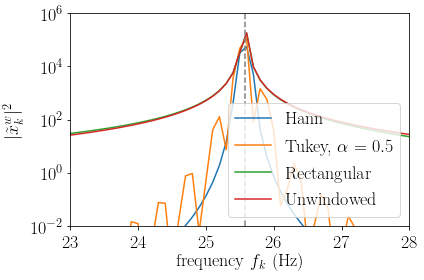

In [15]:
# Plotting the data
fig = plt.figure()
plt.semilogy(f,np.abs(x_tilde_hann)**2, label=r'Hann')
plt.semilogy(f,np.abs(x_tilde_tukey)**2, label=r'Tukey, $\alpha=0.5$')
plt.semilogy(f,np.abs(x_tilde_rect)**2, label=r'Rectangular')
plt.semilogy(f,np.abs(x_tilde)**2, label=r'Unwindowed')
plt.xlabel(r'frequency $f_k$ (Hz)')
plt.ylabel(r'$|\tilde{x}^w_k|^2$')
plt.axvline(25.57, color='grey', linestyle='--')
plt.xlim(23,28)
plt.ylim(1e-2,1e6)
plt.axvline(fs/2, color='grey', alpha=0.5, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

And now for a bin centered spectral line:

In [16]:
A = 1; k = T*25.5; phi_0 = np.pi/3
x = A*np.cos(2*np.pi*j*k/N+phi_0)
x_tilde = np.fft.fft(x)

In [17]:
# Multiplying in the time domain
x_tilde_hann = np.fft.fft(x*hann)
x_tilde_tukey = np.fft.fft(x*tukey)
x_tilde_rect = np.fft.fft(x*rect)

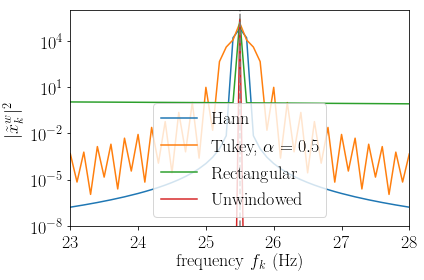

In [18]:
# Plotting the data
fig = plt.figure()
plt.semilogy(f,np.abs(x_tilde_hann)**2, label=r'Hann')
plt.semilogy(f,np.abs(x_tilde_tukey)**2, label=r'Tukey, $\alpha=0.5$')
plt.semilogy(f,np.abs(x_tilde_rect)**2, label=r'Rectangular')
plt.semilogy(f,np.abs(x_tilde)**2, label=r'Unwindowed')
plt.xlabel(r'frequency $f_k$ (Hz)')
plt.ylabel(r'$|\tilde{x}^w_k|^2$')
plt.axvline(25.5, color='grey', linestyle='--')
plt.xlim(23,28)
plt.ylim(1e-8,1e6)
plt.axvline(fs/2, color='grey', alpha=0.5, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

Note that the amplitude of a spectral line must be corrected after the application of a window. This correction for the Hann window is known to be
$$ \tilde{x}_k = 2\tilde{x}^w_k $$
We see this explicitly above as:

In [19]:
print('Amplitude correction : {}'.format(np.max(x_tilde)/np.max(x_tilde_hann)))

Amplitude correction : (2.002002002551168-2.9446953523613035e-10j)


## Power Spectral Densities

We define the one-sided power spectral density (PSD) estimation as
$$ P_k = \frac{2\langle|\tilde{x}_k|^2\rangle \Delta t ^2}{T}$$
where we need to take averages over the the magnitude squared of the Fourier Transform of the signal. 
To demonstrate this, we will construct a PSD with Gaussian noise with a 20 Hz line.

In [105]:
number_fft = 1000
number_averages = 1000

# Setting up the line
A = 1; T_fft = 10 # this is the duration of each FFT
dt = T_fft/ number_fft
frequency = 20.
fs = 1./dt
df = 1./T

# Set up the time array
t = np.arange(0,T_fft*number_averages,dt)
line_total = A*np.cos(2*np.pi*frequency*t)
gaussian_total = np.random.randn(number_fft*number_averages)
x_total = gaussian_total + line_total

In [109]:
x_list = x_total.reshape((number_averages,number_fft))

x_list_tilde = np.fft.rfft(x_list, axis=1) # we use np.fft.rfft to take the real part, limiting the domain to 0 to fs/2 in the frequency

power = 2*np.mean(np.abs(x_list_tilde)**2, axis=0)*dt**2/T_fft
f = np.arange(0, fs/2+df, df)

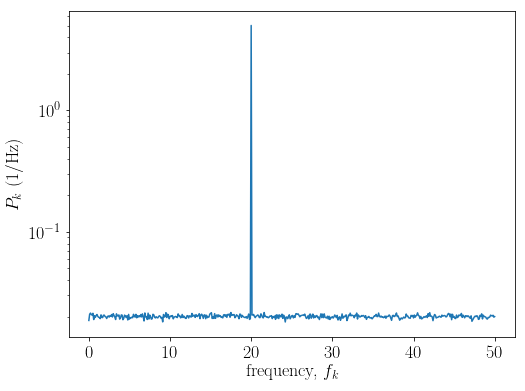

In [110]:
plt.semilogy(f, power)
plt.ylabel(r'$P_k$ ($1/$Hz)')
plt.xlabel(r'frequency, $f_k$')
plt.show()

Here we can therefore see the amount of power located at 20 Hz due to the line in the data at this point. Now, we can look at how the PSD relates to the standard deviation of the Gaussian white noise. 

Considering a signal constructed entirely of white noise, e.g. `gaussian_noise` array we have constructed, $\tilde{n}_k$. Then we can note that 
$$ \langle|\tilde{n}_k|^2\rangle = N\sigma^2 $$
where $\sigma$ is the standard deviation of the Gaussian distribution. Therefore, we can see that 
$$ P_k  = \frac{2 N\sigma^2 \Delta t ^2}{T} = 2\sigma^2\Delta t = \frac{2\sigma^2}{f_s}$$

Therefore we can actually plot $\sigma^2(f)$ as $P_k\times f_s/2$. As shown below:

In [111]:
gaussian_list = gaussian_total.reshape((number_averages,number_fft))
n_list_tilde = np.fft.rfft(gaussian_list, axis=1)
power = 2*np.mean(np.abs(n_list_tilde)**2, axis=0)*dt**2/T_fft

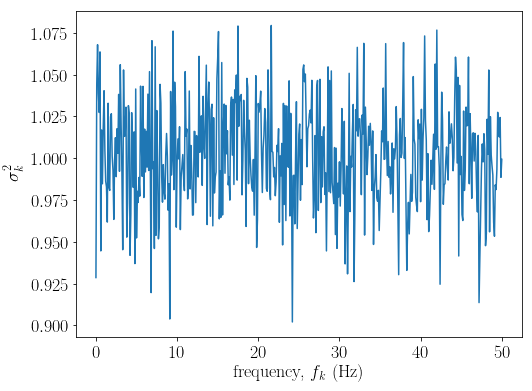

In [112]:
plt.plot(f, power*fs/2)
plt.ylabel(r'$\sigma^2_k$')
plt.xlabel(r'frequency, $f_k$ (Hz)')
plt.show()

Now, it can be asked "well why is this a density?" To answer this, simply consider the discrete integral of $P_k$ from $k=0$ to $N/2$. Then we get:
$$\sum_{k=0}^{N/2} P_k\Delta f = \sum_{k=0}^{N/2} \frac{2\sigma^2}{f_s} \frac{1}{T} = \frac{2\sigma^2}{N} \frac{N}{2} = \sigma^2 $$
where we assume $\sigma^2$ is constant (which is true for Gaussian while noise as well as for any arbitrarily small region about a particular frequency). 

### PSD Corrections

Again, when windowing the data we again need to correct the $|\tilde{n}_k|^2$ term. It can be found that 
$$ |\tilde{n}_k|^2 = \frac{8}{3}|\tilde{n}^w_k|^2$$ 
for the Hann window. This is demonstrated below:

In [113]:
# Generate our time domain data
N = 10000; T = 100
dt = T/N; fs = N/T
n = np.random.randn(N)

# Compute the frequency domain data
df = 1/T
n_tilde = np.fft.rfft(n)
f = np.arange(0, fs/2+df, df)

# compute the windowed results:
hann = np.hanning(N)
n_window_tilde = np.fft.rfft(hann*n)

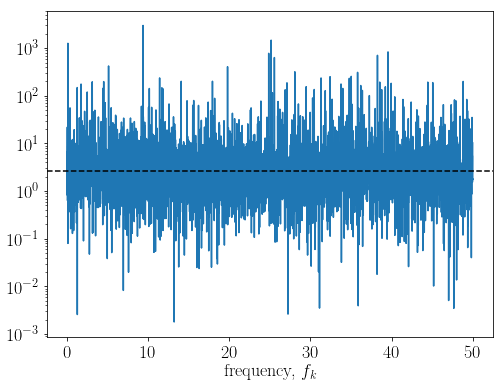

In [114]:
plt.semilogy(f, np.abs(n_tilde)**2/np.abs(n_window_tilde)**2)
plt.axhline(8/3,color='k',linestyle='--')
plt.xlabel(r'frequency, $f_k$')
plt.show()

In [115]:
# TODO ask greg about this as the same doesnt seem to be a constant correction.... 

### Windowing PSDs

It is important for PSDs to be windowed in order to mitigate leakage from frequency dependent gaussian noise located in other bins. For example in LIGO, the high amplitude low frequency noise can leak into the bucket of the instrument without the appropriate windowing. This is demonstated below with a sample PSD. We extract the `H1:GDS_CALIB_STRAIN` for this calculation.

In [116]:
T = 1000 # duration
start_time = 1248912018
fs = 16384 #Hz as set by the channel system
N_total = fs*T
dt = 1/fs
df = 1/T
t = np.linspace(start_time, start_time+T, N_total)

# Connect and gather the strain data from the interferometer
conn = nds2.connection('nds.ligo-wa.caltech.edu' , 31200) 
print('Connected')
conn.set_parameter('ALLOW_DATA_ON_TAPE', '1')

print('\nAcquiring data, note that this may take some time - NDS2 is slow')
buffer = conn.fetch(start_time,start_time+T, ['H1:GDS-CALIB_STRAIN'])
x_total = buffer[0].data
print('Data Acquired')

Connected

Acquiring data, note that this may take some time - NDS2 is slow
Data Acquired


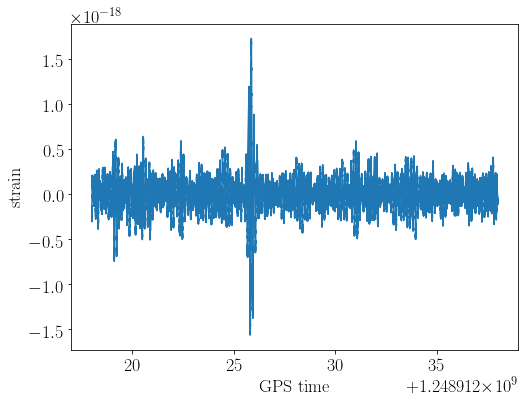

In [117]:
plt.plot(t[:int(N_total/50)],x_total[:int(N_total/50)])
plt.xlabel(r'GPS time')
plt.ylabel(r'strain')
plt.show()

In [118]:
number_averages = 100; number_fft = int(N_total/number_averages)
T_fft = float(number_fft)/fs
df = 1/T_fft

x_list = x_total.reshape((number_averages,number_fft))
x_list_tilde = np.fft.rfft(x_list, axis=1) # we use np.fft.rfft to take the real part, limiting the domain to 0 to fs/2 in the frequency

power = 2*np.mean(np.abs(x_list_tilde)**2, axis=0)*dt**2/T_fft
f = np.arange(0, fs/2+df, df)

We will also Hann window each noise realization which is fed into the calculation of the PSD to see the effect:

In [119]:
hann = np.hanning(number_fft)
x_list_tilde = np.fft.rfft(x_list*hann, axis=1) # we use np.fft.rfft to take the real part, limiting the domain to 0 to fs/2 in the frequency

power_hann = 2*np.mean(np.abs(x_list_tilde)**2, axis=0)*dt**2/T_fft

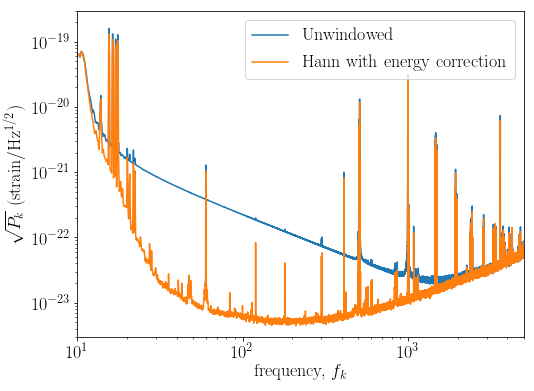

In [122]:
plt.loglog(f, np.sqrt(power), label='Unwindowed')
plt.loglog(f, np.sqrt(power_hann*8./3), label='Hann with energy correction')
plt.xlim(10,5000)
plt.ylim(3e-24,3e-19)
plt.ylabel(r'$\sqrt{P_k}$ (strain$/$Hz$^{1/2}$)')
plt.xlabel(r'frequency, $f_k$')
plt.legend()
plt.show()